In [1]:
import pandas as pd
from transformers import pipeline
from scipy.stats import zscore
import numpy as np
from sentence_transformers import SentenceTransformer

/Users/stefano/Documents/projects/RLPT/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('in_domain_train.tsv', sep='\t', names=["source", "label", "unused", "text"])

In [27]:
classifier = pipeline(
    "text-classification", 
    model="sgugger/bert-fine-tuned-cola", 
)

In [48]:
texts = df["text"].tolist()
preds = classifier(texts)

In [49]:

predicted_binary = [0 if p['label'] == 'unacceptable' else 1 for p in preds]
actual_binary = df["label"].tolist()
correct_predictions = sum(p == a for p, a in zip(predicted_binary, actual_binary))
total_predictions = len(actual_binary)
accuracy = correct_predictions / total_predictions

print(f"Accuracy: {accuracy}")

Accuracy: 0.9718161618524149


In [79]:
predictions = pd.Series([p['score'] for p in preds])
z_scores = zscore(predictions)


threshold = 3
prediction_filtered = predictions[np.abs(z_scores) < threshold]

In [70]:
predictions.to_csv('predictions.csv', index=False)

In [58]:
len(prediction_filtered), len(predictions)

(8466, 8551)

In [81]:

min_prediction = prediction_filtered.min()
std_prediction = prediction_filtered.std()
print(f"Minimum prediction score: {min_prediction}")
print(f"Standard deviation of prediction scores: {std_prediction}")


Minimum prediction score: 0.9224411845207214
Standard deviation of prediction scores: 0.005232337081093689


<Axes: >

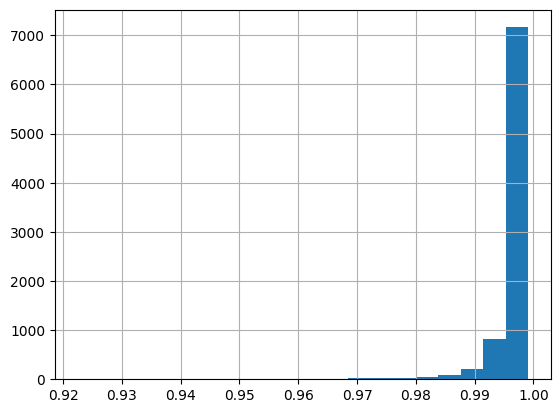

In [82]:
prediction_filtered.hist(bins=20)

In [84]:
df['scores'] = predictions
df['normalized_score'] = df['scores'].apply(lambda x: (x - min_prediction) /  std_prediction if x > min_prediction else min_prediction)
df

,source,label,unused,text,scores,normalized_score
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone...",0.997613,14.366767
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.,0.997344,14.315402
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.,0.997527,14.350284
3,gj04,1,NaN,"The more we study verbs, the crazier they get.",0.998158,14.470966
4,gj04,1,NaN,Day by day the facts are getting murkier.,0.997599,14.364045
...,...,...,...,...,...,...
8546,ad03,0,*,Poseidon appears to own a dragon,0.998427,14.522262
8547,ad03,0,*,Digitize is my happiest memory,0.995859,14.031592
8548,ad03,1,NaN,It is easy to slay the Gorgon.,0.998911,14.614899
8549,ad03,1,NaN,I had the strangest feeling that I knew you.,0.998144,14.468289


In [85]:
df.to_csv('predictions_with_normalized_scores.csv', index=False)

In [3]:
model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)
sentences = df['text'].tolist()
embeddings = model.encode(sentences, show_progress_bar=False)
output_file = 'text_embeddings.npy'
np.save(output_file, embeddings)

In [5]:
a = np.load(output_file)
a.shape

(8551, 384)